In [360]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
#from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
from skmultilearn.model_selection import IterativeStratification
import sklearn.preprocessing as pp
from sklearn.svm import l1_min_c
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sb

import stages_DE.stages_library
import importlib
importlib.reload(stages_DE.stages_library)

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES, summary_classification, summary_classification_print_sort, scatter_catgory
import stages_DE.OvR as OvR
importlib.reload(OvR)

<module 'stages_DE.OvR' from '/home/khrovatin/git/baylor-dicty/stages_DE/OvR.py'>

In [ ]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
    dataPath= '/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

In [308]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

# Retain only samples with annotations
Y = conditions[(conditions[PHENOTYPES] != 0).any(axis=1)]
#X = genes[Y.Measurment].T.values
X = genes[Y.Measurment].T

# Remove targets with too little positive samples
order=['no_agg','disappear', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB']
Y = Y[order].values

# Remove constant features
#X=X[:,(X.std(axis=0)!=0)]
X=X.loc[:,X.std(axis=0)!=0]
feature_names=X.columns
X=X.values

## Cross validation for selection of regularisation constant

In [ ]:
parameter_list=[]
for c in [0.1,0.3,0.6,0.8,1,1.3,1.6,1.8,2,5,10]:
    parameter_list.append({'penalty':'l1','C':c,'class_weight':'balanced'})

In [ ]:
prfs_all=pd.DataFrame()
rac_all=pd.DataFrame()
feats_all=pd.DataFrame()
split = IterativeStratification(n_splits=5, order=1)
fold=0
                
# Cross validation
for train_index, test_index in split.split(X, Y):
    fold += 1
    print(fold)
    scaler = pp.MinMaxScaler()
    #Scale X features to [0,1], use X_train_fold scaller to also scale X_test_fold
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]
    X_train_fold=scaler.fit_transform(X_train_fold)
    X_test_fold=scaler.transform(X_test_fold)
    # Different regularization strengths - none or 1 
    for params in parameter_list:
        c=''
        for param_value in params.values():
            c=c+str(param_value)+'_'
        c=c.rstrip('_')
        print('C:',c)
        classifier = OneVsRestClassifier(
            # saga is only solver that supports no penaly and penalty = l1. 
            estimator=LogisticRegression( n_jobs=20,  solver='saga',**params),
            n_jobs=Y.shape[1]).fit(X_train_fold,Y_train_fold)
        
        # Quality metrics for the model
        Y_predict_fold = classifier.predict(X_test_fold)
        Y_p_fold = classifier.predict_proba(X_test_fold)
        
        prfs=pd.DataFrame(precision_recall_fscore_support(Y_test_fold, Y_predict_fold),index=['precision','recall','F_score','support']).T
        prfs['Group']=order
        prfs['params']=[c]*prfs.shape[0]
        prfs_all=prfs_all.append(prfs)
        prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='micro'))
        prfs.extend(['micro',c])
        prfs=dict(zip(['precision','recall','F_score','support','Group',"params"],prfs))
        prfs_all = prfs_all.append( prfs,ignore_index=True)
        prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='macro'))
        prfs.extend(['macro',c])
        prfs=dict(zip(['precision','recall','F_score','support','Group',"params"],prfs))
        prfs_all = prfs_all.append( prfs,ignore_index=True)
        
        rac=pd.DataFrame(roc_auc_score(Y_test_fold, Y_p_fold,average=None),columns=['roc_auc'])
        rac['Group']=order
        rac['params']=[c]*rac.shape[0]
        rac_all = rac_all.append(rac,ignore_index=True)
        rac=dict(zip(['roc_auc','Group','params'],[roc_auc_score(Y_test_fold, Y_p_fold, average='micro'),'micro',c]))
        rac_all=rac_all.append(rac,ignore_index=True)
        rac=dict(zip(['roc_auc','Group','params'],[roc_auc_score(Y_test_fold, Y_p_fold, average='macro'),'macro',c]))
        rac_all=rac_all.append(rac,ignore_index=True)
        
        # N used features in the model
        feats_combined = set()
        for i in range(len(order)):
            cl = classifier.estimators_[i]
            feats_stage = set(pd.Series(range(X.shape[1]))[(cl.coef_ != 0).flatten()[:X.shape[1]]].index)
            feats_combined = feats_combined | feats_stage
            #print(len(feats_stage), len(feats_combined))
            feats=dict(zip(['N_features','params','Group'],[len(feats_stage),c,order[i]]))
            feats_all=feats_all.append(feats,ignore_index=True)
        feats= dict(zip(['N_features', 'params', 'Group'],[len(feats_combined), c, 'all']))
        feats_all = feats_all.append(feats,ignore_index=True)
savePickle(pathClassification+'logisticRegressionBinaryRelevanceRegularisation5fold.pkl',{'prfs':prfs_all,'rac':rac_all,'featsN':feats_all})

In [ ]:
result=loadPickle(pathClassification+'logisticRegressionBinaryRelevanceRegularisation5fold.pkl')

In [130]:
prfs=result['prfs'].query('Group=="macro"').copy()
prfs['C']=[float(param.split('_')[1]) for param in prfs['params']]
error_bars = alt.Chart(prfs).mark_errorbar(extent='stderr').encode(
  x=alt.X('C:N', scale=alt.Scale(zero=False)),
  y=alt.Y('F_score:Q')
).properties(title='Macro F score - marked mean and SE')

points = alt.Chart(prfs).mark_point(filled=True, color='black').encode(
  x=alt.X('C:N'),
  y=alt.Y('F_score:Q', aggregate='mean', scale=alt.Scale(zero=False)),
)
error_bars +points

alt.LayerChart(...)

In [143]:
featsN=result['featsN']
featsN['C']=[float(param.split('_')[1]) for param in featsN['params']]

base=alt.Chart(featsN,width=70).encode(
    x=alt.X('Group',title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False)),
    y='N_features:Q',
    color='Group',
)

alt.layer(
  base.mark_errorbar(extent='stderr').encode(
  x=alt.X('Group:N', scale=alt.Scale(zero=False),title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False)),
  y=alt.Y('N_features:Q')
),
  base.mark_point().encode(x=alt.X('Group:N',title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False)),
  y=alt.Y('N_features:Q', aggregate='mean', scale=alt.Scale(zero=False)))
).facet(
  column=alt.Column('C', header=alt.Header(titleOrient='bottom',labelOrient='bottom'))
).configure_facet(spacing=-10).properties(title='N features used by each OvR model and "all" together')


alt.FacetChart(...)

## Regularisation path on whole data set

In [310]:
X_model=pp.minmax_scale(X)

In [213]:
min_c=np.inf
for i in range(Y.shape[1]):
    c = l1_min_c(X_model, Y[:,i], loss='log')
    if c<min_c:
        min_c=c
cs=[min_c,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.3,1.6,1.9,2.5,5,10]

In [ ]:
coefs = []
first=True
classifier=None
for c in cs:
    print(c)
    if first:
        classifier = OvR.OneVsRestClassifier(estimator=LogisticRegression(n_jobs=20,  solver='saga',
                                                    penalty='l1',class_weight='balanced',
                                                    warm_start=True, C=c),
                                        n_jobs=Y.shape[1],warm_start=True)
    else:
        for e_idx in range(len(classifier.estimators_)):
            classifier.estimators_[e_idx]=classifier.estimators_[e_idx].set_params(C=c)
    classifier.fit(X_model, Y)
    #print('*****',classifier.estimators_)
    #Not same IDs as clones the object when fitting?
    #for clf in classifier.estimators_:
    #    print(id(clf))
    coefs_list=[]
    for estimator in classifier.estimators_:
        coefs_list.append(estimator.coef_.ravel().copy())
    coefs.append(coefs_list)
    first=False
coefs=np.array(coefs)

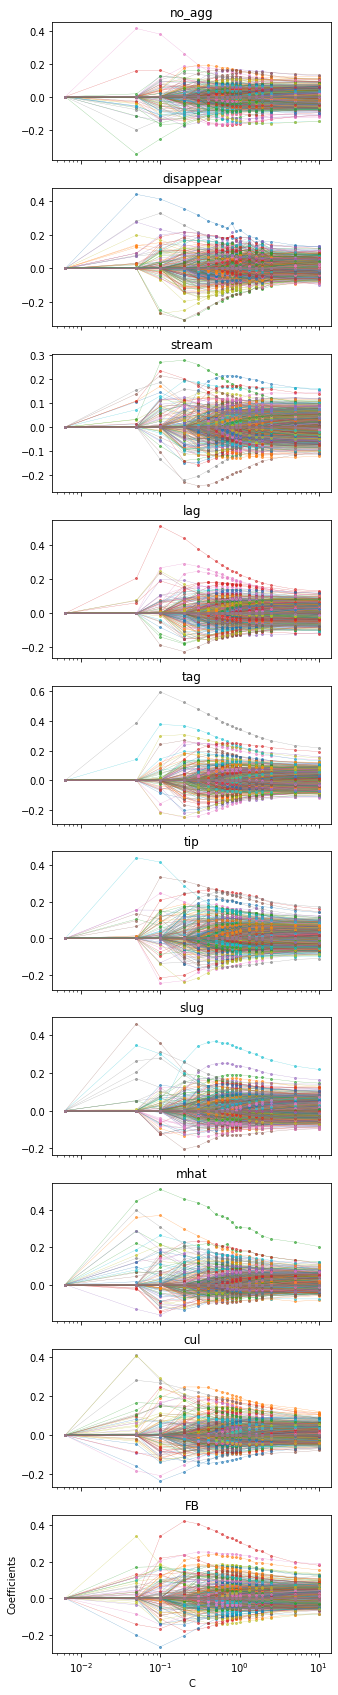

In [231]:
f, axs = plt.subplots(Y.shape[1], 1,figsize=(5,30), sharex='col')
plt.xlabel('C')
plt.ylabel('Coefficients')
for idx,phenotype in enumerate(order):
    coefs_ = coefs[:,idx,:]
    for feat in range(coefs_.shape[1]):
        axs[idx].plot(cs, coefs_[:,feat], marker='o',alpha=0.6,linewidth=0.3, markersize=2)
    ymin, ymax = axs[idx].set_ylim()
    axs[idx].set_xscale('log')
    axs[idx].set_title(phenotype)

In [278]:
#N used features at different C
coefs_summary=[]
for idx_c,c in enumerate(cs):
    n_all=(coefs[idx_c,:,:]!=0).any(axis=0).sum()
    coefs_summary.append({'C':c,'Group':'all','N features':n_all,'Weight_size':'all'})
    for idx_pheno,phenotype in enumerate(order):
        coefs_model=coefs[idx_c,idx_pheno,:]
        coefs_summary.append({'C':c,'Group':phenotype,'N features':(coefs_model!=0).sum(),
                              'Weight_size':'all'})
        coefs_summary.append({'C':c,'Group':phenotype,'N features':(coefs_model>0).sum(),
                              'Weight_size':'positive'})
        coefs_summary.append({'C':c,'Group':phenotype,'N features':(coefs_model<0).sum(),
                              'Weight_size':'negative'})
coefs_summary=pd.DataFrame(coefs_summary)

In [279]:
base=alt.Chart(coefs_summary[coefs_summary['Weight_size'].isin(['all','positive'])],width=50).encode(
    x=alt.X('Group',title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False)),
    y='N features:Q',
    color='Group',
    shape=alt.Shape('Weight_size',scale = alt.Scale(range=["circle", "triangle-up"]))
)

alt.layer(
  base.mark_point().encode(
  x=alt.X('Group:N', scale=alt.Scale(zero=False),title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False)),
  y=alt.Y('N features:Q')
)
).facet(
  column=alt.Column('C', header=alt.Header(titleOrient='bottom',labelOrient='bottom'))
).configure_facet(spacing=-20).properties(title='N features used by each OvR model and "all" together')


alt.FacetChart(...)

In [383]:
coefs_summary.query('C ==0.2 &  Weight_size =="positive"')

,C,Group,N features,Weight_size
436,0.2,no_agg,81,positive
439,0.2,disappear,92,positive
442,0.2,stream,83,positive
445,0.2,lag,98,positive
448,0.2,tag,72,positive
451,0.2,tip,87,positive
454,0.2,slug,99,positive
457,0.2,mhat,80,positive
460,0.2,cul,108,positive
463,0.2,FB,94,positive


## Select regularised positive features for each stage

Make new regularised classifier (regularisation=c).

In [384]:
c=0.2
classifier = OvR.OneVsRestClassifier(estimator=LogisticRegression(n_jobs=20,  solver='saga',
                                                    penalty='l1',class_weight='balanced',
                                                    warm_start=True, C=c),
                                        n_jobs=Y.shape[1],warm_start=True).fit(X_model, Y)

(Re)setting estimators


Extract positive weighted features (genes) for each class (developmental stage).

In [385]:
positive_features_classes=pd.DataFrame()
for stage,estimator in zip(order,classifier.estimators_):
    coefs=estimator.coef_.ravel().copy()
    positive_features=feature_names[coefs>0]
    positive_features=pd.Series([1]*positive_features.shape[0],index=positive_features,name=stage)
    positive_features_classes=positive_features_classes.append(positive_features)

In [386]:
print('Features positive in at least one stage:',positive_features_classes.shape[1])
print('Positive features per stage:')
print(positive_features_classes.sum(axis=1).astype('int'))

Features positive in at least one stage: 752
Positive features per stage:
no_agg        80
disappear     92
stream        82
lag           96
tag           71
tip           88
slug          99
mhat          79
cul          110
FB            94
dtype: int64


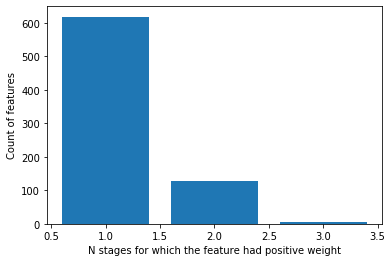

In [395]:
sum_stages=positive_features_classes.sum()
n_stages_data=[]
count=[]
for n_stages,data in pd.DataFrame(positive_features_classes.sum()).groupby(0):
    n_stages_data.append(n_stages)
    count.append(data.shape[0])

plt.bar(n_stages_data,count)
plt.xlabel('N stages for which the feature had positive weight')
a=plt.ylabel('Count of features')

Positive weighted features across stages:
Features are on y axis, positive are coloured in dark blue.



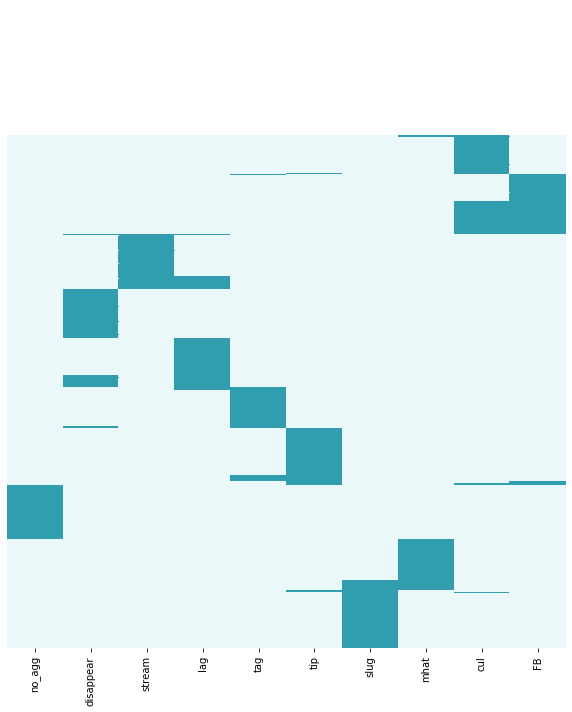

In [388]:
print('Positive weighted features across stages:\nFeatures are on y axis, positive are coloured in dark blue.\n')
g=sb.clustermap(positive_features_classes.replace(np.nan,0).T,col_cluster=False, yticklabels=False,
           cmap=sb.light_palette((210, 90, 60), input="husl"), cbar=False)
g.cax.set_visible(False)
#g.cax.set_title('Positive weighted features across stages:\ny axis, coloured in dark blue.\n',fontsize=15)
g.ax_row_dendrogram.set_visible(False)

In [397]:
positive_features_classes.replace(np.nan,0).to_csv(pathClassification+'selectedPositiveFeatures_c'+str(c)+'.tsv',sep='\t')

In [396]:
pathClassification+'selectedPositiveFeatures_c'+str(c)+'.tsv'

'/home/khrovatin/timeTrajectoriesNet/data/stages/classification/selectedPositiveFeatures_c0.2.tsv'